In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Skeleton.zip', 'r')
zip_ref.extractall('./')

zip_ref.close()

In [0]:
import scipy.io
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt

In [0]:
#https://github.com/woo-chia-wei/kinect-sequence-classification
def import_skeleton_data(action, subject, trial):
    filename = f'Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    #print(Path(filename).is_file())
    #if Path(filename).is_file():
    mat = scipy.io.loadmat(filename)
    return mat['d_skel']
  #  else:
  #      return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    #print(data.shape)
    if data is None: return None
    #print(data[:,0,0])
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    #print(result)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    #print(data.shape)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df



In [0]:


data_columns = ['head','shoulder_center', 'spine','hip_center' ,'left_shoulder','left_elbow','left_wrist','left_hand','right_shoulder','right_elbow','right_wrist','right_hand','left_hip',
              'left_knee','left_ankle','left_foot','right_hip','right_knee','right_ankle','right_foot' ]
columns = data_columns + ['action']

In [0]:
def change_data(frame):
    keys = np.array(frame['skeleton_joint'])
    joint = 1
    dfx = pd.DataFrame(columns = columns)
    dfy = pd.DataFrame(columns = columns)
    dfz = pd.DataFrame(columns = columns)
    dfx['action'] = frame['action']
    dfy['action'] = frame['action']
    dfz['action'] = frame['action']
    for i in range(len(data_columns)):
       
        #print(i)
        dfx[data_columns[i]] = np.array(frame.x)* np.where(keys ==joint, keys, 0)
        #print(i)
        
        dfy[data_columns[i]] = np.array(frame.y)* np.where(keys ==joint, keys, 0)

        
        dfz[data_columns[i]] = np.array(frame.z)* np.where(keys ==joint, keys, 0)
        joint += 1
   
    return dfx, dfy, dfz

In [0]:
subjects_x = []
subjects_y = []
subjects_z = []
for a in range(1,28):
    for s in range(1,9):
        for t in range(1,5):
            try:
                df = transform_skeleton_data_to_df(a, s, t)
                #print(len(df))
                dfx, dfy, dfz = change_data(df)
                subjects_x.append(dfx)
                subjects_y.append(dfy)
                subjects_z.append(dfz)
            except FileNotFoundError:
                pass

In [0]:
def reduce(list_of_df):
    new_subjects = []
    for df in list_of_df:
        assert(len(df.action.unique()) == 1)


        new = pd.DataFrame(columns = list(df))

        for col in list(df):
            if col != 'action':
                dat = np.array(df[col])
                dat = dat[dat != 0.]
                new[col] = dat
        new['action'] = df.action.unique()[0]
        new_subjects.append(new)
    return new_subjects

In [0]:
list_x = reduce(subjects_x)
list_y = reduce(subjects_y)
list_z = reduce(subjects_z)

In [0]:

cat_np = []
targets = np.array([])
for i in range(len(list_x)):
    df = list_x[i].append(list_y[i], ignore_index =True)
    df = df.append(list_z[i], ignore_index = True)
    assert(len(df.action.unique()) == 1)
    targets = np.append(targets, df.action.unique()[0])
    df = df.drop(['action'], axis=1)
    cat_np.append(df.T.to_numpy())
    

In [0]:
max_frames = 0
min_frames = 400
ave = 0
for i in range(len(cat_np)):
    t = cat_np[i].shape[1]
    if t > max_frames:
        max_frames = t
    if t < min_frames:
        min_frames = t
    ave += t
ave = ave / len(cat_np)

In [12]:
max_frames, min_frames, ave

(375, 123, 203.13240418118468)

In [0]:
transformed_data = []
for video in cat_np:
    
    if video.shape[1] > 201:
        video = video[:, :201]
    
    c_min = np.amin(video, axis=1, keepdims=True)
    c_max = np.amax(video, axis=1, keepdims=True)
    max_k = np.amax(c_max - c_min)
    P = np.floor(255. * (video - c_min) / max_k)
    #print( max_k)
    if P.shape[1] < 201:
        zeros = np.zeros((P.shape[0], 201- P.shape[1]))
        P = np.hstack((P, zeros))
    transformed_data.append(P)

In [0]:
targets -= 1

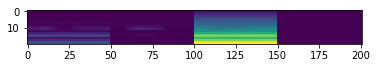

In [15]:
plt.imshow(transformed_data[10])

In [0]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [0]:
new = []
mask = []
for i in range(len(transformed_data)):
#i = 0
    image = transformed_data[i]
    label = targets[i]
   
 
    aug = HorizontalFlip(p=1)

    augmented = aug(image=image)
    image_h_flipped = augmented['image']

    new.append(image_h_flipped)
    
    mask.append(label)
   
    aug = VerticalFlip(p=1)

    augmented = aug(image=image)

    image_v_flipped = augmented['image']
    new.append(image_v_flipped)
    
    mask.append(label)


In [0]:
transformed_data += new
#targets += mask

In [0]:
mask = np.array(mask)
targets=  np.append(targets, mask)

In [20]:
len(transformed_data)

2583

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from google.colab import files
import torch.nn as nn
import torch
import torchvision
import os
import torch.optim as optim
import torchvision.transforms as transforms

from torch.autograd import Variable

import math

In [0]:

import torch.utils.data
from sklearn.model_selection import train_test_split
import torch

class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, data, targets, fold='train'):
        self.fold = fold
      
        

        X_train, X_, y_train, y_ = train_test_split( data, targets, train_size=0.7, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.6, random_state=42)
        self.train_data = torch.FloatTensor(X_train)
        self.train_labels = torch.LongTensor(y_train)
        
        self.val_data = torch.FloatTensor(X_val)
        self.val_labels = torch.LongTensor(y_val)
        self.test_data = torch.FloatTensor(X_test)
        self.test_labels = torch.LongTensor(y_test)
      
    def __len__(self):
        if self.fold == 'train':
            return len(self.train_data)
        elif self.fold == 'val':
            return len(self.val_data)
        elif self.fold == 'test':
            return len(self.test_data)
     
            
  

    def __getitem__(self, index):
      
        if self.fold == 'train':
            data = self.train_data[index]
            label =  self.train_labels[index]
        elif self.fold == 'val':
            data = self.val_data[index]
            label =  self.val_labels[index]
        elif self.fold == 'test':
            data = self.test_data[index]
            label =  self.test_labels[index]
        return data,label

In [0]:
train_dataset = Dataset(transformed_data, targets,fold='train')

In [0]:
val_dataset = Dataset(transformed_data, targets,fold='val')
test_dataset = Dataset(transformed_data, targets,fold='test')

In [25]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

1808 465 310


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=50,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=50,shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=50,shuffle=False)

In [0]:
import torchvision.models as models


In [28]:
#https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb#scrollTo=XVeRWfblXYOY
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [0]:
# Number of classes in the dataset
num_classes = 27

# Batch size for training (change depending on how much memory you have)
batch_size = 50

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                labels = labels.to(device)
                """
                inputs = torch.transpose(inputs, 1, 2)
                inputs = nn.Linear(20,3)(inputs)
                inputs = torch.transpose(inputs, 1, 2)
                inputs = inputs.unsqueeze(3)\
                """
                #print(inputs.shape)
                try:
                    inputs = inputs.view(50, 3, 20, 67)
                except RuntimeError:
                    inputs = inputs.view(-1, 3, 20, 67)
                inputs = inputs.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #print(outputs.shape)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [44]:
def initialize_model( model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model("vgg", num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#Tprint(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 531503671/531503671 [00:17<00:00, 29694219.86it/s]


In [45]:

# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0004, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [46]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
model_name = "vgg"

# Train and evaluate

model_ft, hist = train_model(model_ft, {'train':train_loader, 'val':val_loader}, criterion, optimizer_ft, num_epochs=500, is_inception=(model_name=="inception"))

Epoch 0/499
----------
train Loss: 3.2991 Acc: 0.0465
val Loss: 3.2372 Acc: 0.1161

Epoch 1/499
----------
train Loss: 3.1824 Acc: 0.1051
val Loss: 3.0980 Acc: 0.1613

Epoch 2/499
----------
train Loss: 2.9695 Acc: 0.1753
val Loss: 2.8674 Acc: 0.2065

Epoch 3/499
----------
train Loss: 2.6776 Acc: 0.2489
val Loss: 2.5882 Acc: 0.2409

Epoch 4/499
----------
train Loss: 2.3604 Acc: 0.3330
val Loss: 2.3158 Acc: 0.3247

Epoch 5/499
----------
train Loss: 2.0307 Acc: 0.4110
val Loss: 2.0424 Acc: 0.3763

Epoch 6/499
----------
train Loss: 1.7674 Acc: 0.4867
val Loss: 1.8247 Acc: 0.4151

Epoch 7/499
----------
train Loss: 1.4851 Acc: 0.5431
val Loss: 1.6341 Acc: 0.4559

Epoch 8/499
----------
train Loss: 1.2581 Acc: 0.6167
val Loss: 1.5072 Acc: 0.4968

Epoch 9/499
----------
train Loss: 1.0906 Acc: 0.6692
val Loss: 1.3605 Acc: 0.5290

Epoch 10/499
----------
train Loss: 0.9444 Acc: 0.6975
val Loss: 1.3309 Acc: 0.5312

Epoch 11/499
----------
train Loss: 0.8061 Acc: 0.7555
val Loss: 1.1940 Acc

In [52]:

model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

In [0]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=False)

In [0]:
for batch in test_loader:
    
    data,reference = batch
    data = data.view(310, 3, 20, 67)
   
    data = data.to(device)
    predictions = model_ft(data)
    

Validation accuracy 0.7698924731182796
Test_accuracy 0.8161290287971497


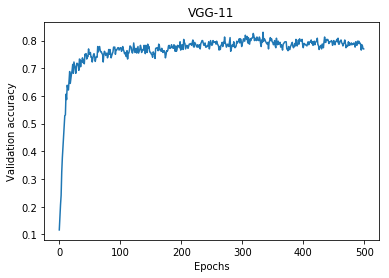

In [55]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('VGG-11')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))

Validation accuracy 0.3419354838709677
Test_accuracy 0.32692307233810425


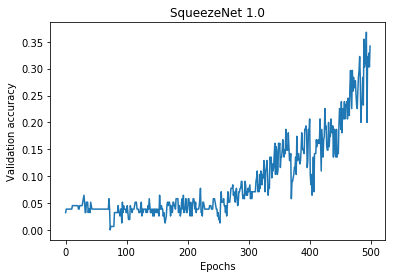

In [0]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('SqueezeNet 1.0')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))

Validation accuracy 0.7483870967741936
Test_accuracy 0.692307710647583


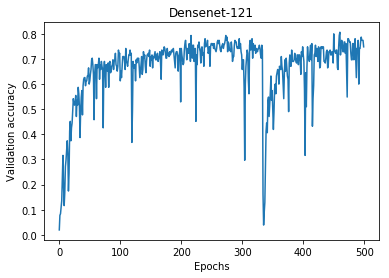

In [0]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('Densenet-121')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))